In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Subset, Dataset, random_split

import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
!pip install torchvision transforms


- Supervised learning용 변환: 단순한 수평 뒤집기와 정규화 적용
- Self-Supervised Learning용 변환:
- RandomResizedCrop: 이미지 크기 조절
- ColorJitter: 밝기, 대비 변화
- RandomGrayscale: 20% 확률로 흑백 변환
- RandomHorizontalFlip: 좌우반전

In [9]:
# 데이터셋 로드 

sl_transform_labeled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_unlabeled = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


- 전체 CIFAR-100 데이터셋을 90% Unlabeled / 10% Labeled로 분할
- Unlabeled 데이터는 SimCLR pretraining에 사용
- Labeled 데이터는 Supervised fine-tuning에 사용

In [10]:
# data set , validation set 분리
dataset = datasets.CIFAR100(root='./data', train=True, download=True)
valset = datasets.CIFAR100(root='./data', train=False, download=True, transform=sl_transform_labeled)

unlabeled_size = int(0.9 * len(dataset))  # 90% 데이터를 unlabel로 (45000개 데이터)
labeled_size = len(dataset) - unlabeled_size  # 10% 데이터를 label로 (5000개 데이터)
unlabeled_dataset, labeled_dataset = random_split(dataset, [unlabeled_size, labeled_size])

print(unlabeled_size)
print(labeled_size)
print(len(unlabeled_dataset), len(labeled_dataset))

Files already downloaded and verified
Files already downloaded and verified
45000
5000
45000 5000


In [11]:
# custom subset - label data와 simCLR 데이터에 각각 transform 적용. img를 처리하기 전에 전역적으로 적용

class SimCLRDataset(Dataset): 
    def __init__(self, dataset, transform1, transform2):
        self.dataset = dataset
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]

        if isinstance(img, torch.Tensor):  # random_split를 통해 tensor로 변환되므로 PIL이미지로 바꿔서 transform을 적용해주어야 흠
            img = transforms.ToPILImage()(img)

        xi = self.transform1(img)
        xj = self.transform2(img)
        return xi, xj
    
# SimCLR 데이터셋 생성
simclr_dataset = SimCLRDataset(unlabeled_dataset, transform_unlabeled, transform_unlabeled)

# Labeled 데이터셋 transform 적용 (labeled dataset은 supervised learning에 사용)
labeled_dataset.dataset.transform = sl_transform_labeled


In [12]:
# 데이터셋 확인

test_size = int(0.8 * len(valset))  # 80% 데이터를 testset으로 (8000개 데이터)
val_size = len(valset) - test_size  # 20% 데이터를 validationset으로 (2000개 데이터)
test_dataset, val_dataset = random_split(valset, [test_size, val_size])

print("test size :" , test_size)
print("val size :" , val_size)

test size : 8000
val size : 2000


In [15]:
# DataLoader
batch_size = 64

simclr_loader = DataLoader(simclr_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [16]:
print(len(simclr_loader))
print(len(labeled_loader))
print(len(val_loader))
print(len(test_loader))

704
79
32
125


In [17]:
epoch = 20

In [18]:
# ResNet 18로 model 학습

baseline_model = models.resnet18(weights=None, num_classes=100)  # weights=None : pretrained X
baseline_model = baseline_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-6, weight_decay=1e-6)

In [19]:
# 학습


def train_baseline(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device="cuda"):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs): # each epoch
        #train
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train * 100

        # validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val * 100

        # save log
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        # print log
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}%")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [20]:
# test


def test_baseline(model, test_loader, criterion, device="cuda"):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = correct_test / total_test * 100

    print(f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}%")

    return avg_test_loss, test_acc

In [21]:
# baseline model학습 진행
bl_trainloss, bl_valloss, bl_trainacc, bl_valacc = train_baseline(baseline_model, labeled_loader,
                                                                  val_loader, criterion, optimizer,
                                                                  num_epochs=epoch, device=device)

Epoch [1/20] | Train Loss: 4.8889, Train Acc: 0.8000% | Val Loss: 4.8827, Val Acc: 1.1000%
Epoch [2/20] | Train Loss: 4.8679, Train Acc: 1.1000% | Val Loss: 4.8778, Val Acc: 0.9500%
Epoch [3/20] | Train Loss: 4.8594, Train Acc: 0.9000% | Val Loss: 4.8727, Val Acc: 1.1500%
Epoch [4/20] | Train Loss: 4.8421, Train Acc: 0.9600% | Val Loss: 4.8490, Val Acc: 1.2000%
Epoch [5/20] | Train Loss: 4.8205, Train Acc: 1.1600% | Val Loss: 4.8433, Val Acc: 0.9000%
Epoch [6/20] | Train Loss: 4.8060, Train Acc: 1.2600% | Val Loss: 4.8265, Val Acc: 0.9000%
Epoch [7/20] | Train Loss: 4.7865, Train Acc: 1.0800% | Val Loss: 4.8427, Val Acc: 0.7500%
Epoch [8/20] | Train Loss: 4.7639, Train Acc: 1.3800% | Val Loss: 4.8378, Val Acc: 1.4000%
Epoch [9/20] | Train Loss: 4.7491, Train Acc: 1.4200% | Val Loss: 4.8043, Val Acc: 1.5000%
Epoch [10/20] | Train Loss: 4.7454, Train Acc: 1.3800% | Val Loss: 4.7962, Val Acc: 1.2000%
Epoch [11/20] | Train Loss: 4.7276, Train Acc: 1.8000% | Val Loss: 4.7755, Val Acc: 1.800

In [22]:
# baseline model test result


bl_testloss, vl_testacc = test_baseline(baseline_model, test_loader, criterion, device=device)

Test Loss: 4.7344, Test Acc: 1.2375%


In [23]:
# SimCLR을 통해 model 학습

class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = encoder(num_classes=projection_dim)
        self.projection_head = nn.Sequential(
            nn.Linear(projection_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        z = F.normalize(z, dim=1)
        return z

In [24]:
# NT-Xent Loss 정의
def simCLR_nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)

    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    sim_exp = torch.exp(sim / temperature)

    mask = (~torch.eye(2*N, 2*N, dtype=bool)).to(z.device)
    sim_exp = sim_exp.masked_select(mask).view(2*N, -1)

    positive_sim = torch.exp(F.cosine_similarity(z_i, z_j, dim=1) / temperature)
    positive_sim = torch.cat([positive_sim, positive_sim], dim=0)

    loss = -torch.log(positive_sim / sim_exp.sum(dim=1)).mean()
    return loss

In [25]:
# model 및 optimizer 설정

simclr_model = SimCLR(models.resnet18).to(device)
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-6)

In [26]:
# SimCLR - train

def train_simclr(loader, epochs=20):
    simclr_model.train()

    for epoch in range(epochs):
        total_loss = 0
        for xi, xj in loader:
            xi, xj = xi.to(device), xj.to(device)

            optimizer.zero_grad()
            zi = simclr_model(xi)
            zj = simclr_model(xj)

            loss = simCLR_nt_xent_loss(zi, zj)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

In [27]:
train_simclr(simclr_loader, epochs=20)

Epoch [1/20] Loss: 4.8127
Epoch [2/20] Loss: 4.7663
Epoch [3/20] Loss: 4.7201
Epoch [4/20] Loss: 4.6900
Epoch [5/20] Loss: 4.6679
Epoch [6/20] Loss: 4.6377
Epoch [7/20] Loss: 4.6112
Epoch [8/20] Loss: 4.5798
Epoch [9/20] Loss: 4.5448
Epoch [10/20] Loss: 4.5171
Epoch [11/20] Loss: 4.4862
Epoch [12/20] Loss: 4.4669
Epoch [13/20] Loss: 4.4490
Epoch [14/20] Loss: 4.4277
Epoch [15/20] Loss: 4.3975
Epoch [16/20] Loss: 4.3838
Epoch [17/20] Loss: 4.3669
Epoch [18/20] Loss: 4.3506
Epoch [19/20] Loss: 4.3341
Epoch [20/20] Loss: 4.3110


In [29]:
# 분류를 위한 모델- SimCLR로 사전학습한 encoder 사용

class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=100):
        super(Classifier, self).__init__()
        self.encoder = encoder.encoder
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.fc_layers(features)
        return output

In [30]:
# 모델 및 optimizer 설정

classifier_model = Classifier(simclr_model).to(device)
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss().to(device)

In [31]:
# simCLR - train

def train_classifier(loader, val_loader, epochs=20):
    classifier_model.train()

    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    # train
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classifier_model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = total_loss / len(loader)
        accuracy = 100. * correct / total

        # validation
        classifier_model.eval()
        val_total_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = classifier_model(images)
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_total_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total

        # print log
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        classifier_model.train()

        # save log
        train_loss.append(avg_loss)
        train_acc.append(accuracy)
        val_loss.append(avg_val_loss)
        val_acc.append(val_accuracy)

    return train_loss, train_acc, val_loss, val_acc

In [32]:
# execution

train_loss, train_acc, val_loss, val_acc = train_classifier(labeled_loader, val_loader, epochs=20)

Epoch [1/20] Train Loss: 4.6552, Train Accuracy: 0.94%, Validation Loss: 4.6417, Validation Accuracy: 0.85%
Epoch [2/20] Train Loss: 4.6558, Train Accuracy: 0.86%, Validation Loss: 4.6412, Validation Accuracy: 1.10%
Epoch [3/20] Train Loss: 4.6469, Train Accuracy: 0.78%, Validation Loss: 4.6323, Validation Accuracy: 0.90%
Epoch [4/20] Train Loss: 4.6461, Train Accuracy: 1.06%, Validation Loss: 4.6329, Validation Accuracy: 1.25%
Epoch [5/20] Train Loss: 4.6422, Train Accuracy: 1.10%, Validation Loss: 4.6292, Validation Accuracy: 1.10%
Epoch [6/20] Train Loss: 4.6248, Train Accuracy: 1.44%, Validation Loss: 4.6242, Validation Accuracy: 1.20%
Epoch [7/20] Train Loss: 4.6234, Train Accuracy: 1.12%, Validation Loss: 4.6196, Validation Accuracy: 1.35%
Epoch [8/20] Train Loss: 4.6268, Train Accuracy: 1.36%, Validation Loss: 4.6168, Validation Accuracy: 1.60%
Epoch [9/20] Train Loss: 4.6190, Train Accuracy: 1.22%, Validation Loss: 4.6155, Validation Accuracy: 1.35%
Epoch [10/20] Train Loss: 4.

In [34]:
def test_classifier(model, test_loader, criterion, device='cuda'):
    model.eval()
    running_test_loss, correct_test, total_test = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = correct_test / total_test * 100

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    return avg_test_loss, test_acc


In [35]:
test_loss, test_acc = test_classifier(classifier_model, test_loader, criterion, device)

Test Loss: 4.5813, Test Accuracy: 2.05%


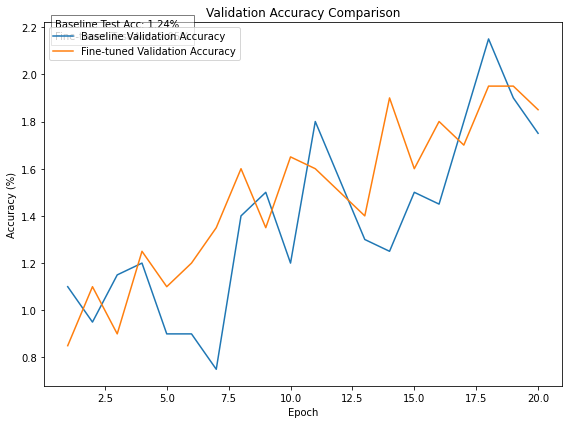

In [36]:
# result visualization

def plot_result(bl_val_acc, val_acc, bl_test_acc, test_acc):

    epochs = range(1, len(bl_val_acc) + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(epochs, bl_val_acc, label='Baseline Validation Accuracy')
    plt.plot(epochs, val_acc, label='Fine-tuned Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    plt.text(0.5, max(max(bl_val_acc), max(val_acc)),
             f'Baseline Test Acc: {bl_test_acc:.2f}%\nFine-tuned Test Acc: {test_acc:.2f}%',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    

# 시각화    
plot_result(bl_valacc, val_acc, vl_testacc, test_acc)

# 결과

loss가 epoch이 진행될수록 감소하는 추세로 미세하게 학습이 이루어졌으나 전반적으로 두 실험 모두 정확도가 매우 낮아(2% 이하) 학습이 정상적으로 이루어졌다고 보기는 어렵다..
SimCLR 기반의 self-supervised learning을 사전학습에 활용한 모델도 baseline 모델 대비 유의미한 성능 개선이 나타나지 않았다.

## 미흡한 점 / 개선점
- lr값(1e-6)이 너무 낮았다.
- CIFAR100은 상대적으로 어려운 데이터셋이므로 더 많은 epoch(50~100 이상)을 학습하거나 batch size를 증가시켜야할 것 같다(학습 소요시간의 단축을 위해 batch size를 작게 하고, epoch를 적게 두었음)